In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Install gdown
!pip install gdown

# Download the file from Google Drive
# https://drive.google.com/file/d/1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz/view?usp=sharing

# !gdown --id 1_1vTv57QQcDCrbV6bzwpgTUZhd4y52ke
!gdown --id 1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
# Extract the tar file
import tarfile

# Open the tar file
with tarfile.open('Augumented_images_new.tar', 'r') as tar:
    tar.extractall()  # Extract to the current working directory

# List the extracted files to verify
import os

# Check the contents of the current directory
print(os.listdir())


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz
From (redirected): https://drive.google.com/uc?id=1oEtO0YA9nHr0H2unX4QR-2bHNX9b-FGz&confirm=t&uuid=008caa56-8b99-46d6-aa9f-a4a3827e892b
To: /kaggle/working/Augumented_images_new.tar
100%|████████████████████████████████████████| 167M/167M [00:06<00:00, 26.6MB/s]
['.virtual_documents', 'Augumented_images_new', 'Augumented_images_new.tar']


In [6]:
import os
import cv2
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTConfig
import matplotlib.pyplot as plt

# Apply DullRazor to all images
def apply_dullrazor(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray_scale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Black hat filter
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray_scale, cv2.MORPH_BLACKHAT, kernel)

    # Gaussian filter
    bhg = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_DEFAULT)

    # Binary thresholding (MASK)
    ret, mask = cv2.threshold(bhg, 10, 255, cv2.THRESH_BINARY)

    # Replace pixels of the mask
    dst = cv2.inpaint(img, mask, 6, cv2.INPAINT_TELEA)

    return dst

In [6]:
# Dataset directory
data_dir = '/kaggle/working/Augumented_images_new'

# Preprocessing transformation (Resize, Normalize)
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),  # ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class for loading and preprocessing the images
class SkinCancerDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = os.listdir(root_dir)
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = apply_dullrazor(img_path)  # Apply hair removal
        if self.transform:
            img = self.transform(img)
        return img, label

In [6]:
# Load Dataset and Create Train/Validation/Test splits
dataset = SkinCancerDataset(data_dir, transform=preprocess)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [6]:
# ViT Model Configuration with dropout
config = ViTConfig.from_pretrained('google/vit-base-patch16-384', 
                                   num_labels=len(dataset.classes), 
                                   hidden_dropout_prob=0.3,   # Dropout in hidden layers
                                   attention_probs_dropout_prob=0.3)  # Dropout in attention layers

# Load Pretrained ViT model with dropout
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384', config=config, ignore_mismatched_sizes=True)
model = nn.DataParallel(model)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and Optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # AdamW with weight decay for L2 regularization

In [6]:
# Training and Validation Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0.0, 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss / len(train_loader))

        model.eval()
        val_loss, correct_val = 0.0, 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss / len(val_loader))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_acc:.4f}')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

# Train the model
train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.au

Epoch 1/30, Train Loss: 0.9317, Train Acc: 0.6403, Val Loss: 0.9065, Val Acc: 0.6987
Epoch 2/30, Train Loss: 0.5179, Train Acc: 0.8016, Val Loss: 0.4901, Val Acc: 0.8089
Epoch 3/30, Train Loss: 0.3777, Train Acc: 0.8564, Val Loss: 0.4348, Val Acc: 0.8661
Epoch 4/30, Train Loss: 0.2552, Train Acc: 0.9053, Val Loss: 0.4694, Val Acc: 0.8312
Epoch 5/30, Train Loss: 0.1922, Train Acc: 0.9302, Val Loss: 0.5617, Val Acc: 0.8368
Epoch 6/30, Train Loss: 0.1641, Train Acc: 0.9422, Val Loss: 0.3061, Val Acc: 0.9031
Epoch 7/30, Train Loss: 0.1294, Train Acc: 0.9571, Val Loss: 0.4258, Val Acc: 0.8689
Epoch 8/30, Train Loss: 0.1088, Train Acc: 0.9626, Val Loss: 0.3846, Val Acc: 0.8794
Epoch 9/30, Train Loss: 0.0958, Train Acc: 0.9653, Val Loss: 0.1911, Val Acc: 0.9344
Epoch 10/30, Train Loss: 0.0849, Train Acc: 0.9703, Val Loss: 0.5267, Val Acc: 0.8515
Epoch 11/30, Train Loss: 0.0865, Train Acc: 0.9740, Val Loss: 0.2663, Val Acc: 0.9240
Epoch 12/30, Train Loss: 0.0779, Train Acc: 0.9746, Val Loss: 0

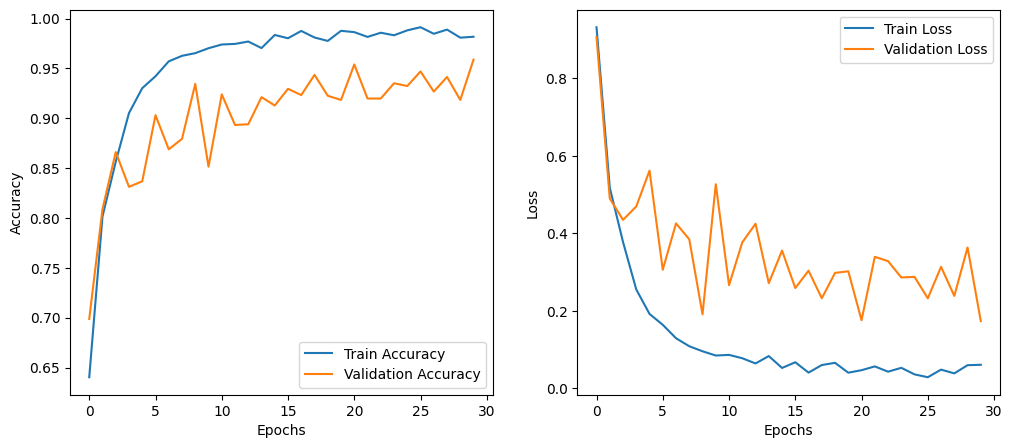

In [6]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# Save the model's state_dict (weights only)
torch.save(model.state_dict(), "skin_cancer_classification_VIT_20epoch_FT.pth")
